In [66]:
import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display, movecol
import os
import matplotlib.pyplot as plt
from itertools import product
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from tqdm.auto import tqdm

from py_files.healper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)
# set max rows for pandas dataframe to 100
pd.set_option("display.max_rows", 100)

DATA_PATH = "data/play_by_play/"

# load ALL of the data and clean it

In [3]:
dataframes = []
for file in sorted(list(os.listdir(DATA_PATH))):
    print(file)
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')
        #df = df[rel_cols]
        dataframes.append(df)
        
df_all = pd.concat(dataframes)
rel_cols = [
    'event_type', 'game_seconds_remaining', 'event_team_type',
    'home_final', 'game_id', 'home_final', 
    'away_final', 'home_name', 'away_name']
df_orig = df_all[rel_cols].copy()
display(df_orig.head(10))

play_by_play_2010_11.csv
play_by_play_2011_12.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2012_13.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2013_14.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (47,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2014_15.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2015_16.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49,55,56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2016_17.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (56,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2017_18.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (47,54,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2018_19.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2019_20.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2020_21.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2021_22.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2022_23.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (48,49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


play_by_play_2023_24.csv


/tmp/ipykernel_72576/1068279475.py:5: DtypeWarning: Columns (42,43,49,50,120,136) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, file), encoding='latin1')


,event_type,game_seconds_remaining,event_team_type,home_final,game_id,home_final,away_final,home_name,away_name
0,GAME_SCHEDULED,3600,NaN,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
1,CHANGE,3600,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
2,CHANGE,3600,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
3,FACEOFF,3600,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
4,HIT,3585,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
5,CHANGE,3572,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
6,CHANGE,3568,home,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
7,CHANGE,3565,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
8,CHANGE,3557,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens
9,HIT,3554,away,3.0000000,2010020001,3.0000000,2.0000000,Toronto Maple Leafs,Montréal Canadiens


In [4]:
certain_game = df_all[df_all['game_id'] == 2010020048].copy()
display(certain_game)

,xg,event_id,event_type,event,secondary_type,event_team,event_team_type,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,event_player_3_name,event_player_3_type,event_goalie_name,strength_state,strength_code,strength,game_winning_goal,empty_net,penalty_severity,penalty_minutes,event_idx,num_on,players_on,num_off,players_off,extra_attacker,x,y,x_fixed,y_fixed,shot_distance,shot_angle,home_skaters,away_skaters,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_on_6,home_on_7,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_on_6,away_on_7,home_goalie,away_goalie,game_id,event_player_1_id,event_player_1_link,event_player_1_season_total,event_player_2_id,event_player_2_link,event_player_2_season_total,event_player_3_id,event_player_3_link,event_player_3_season_total,event_player_4_id,event_player_4_name,event_player_4_link,event_player_4_type,period_type,ordinal_num,period_time,period_time_remaining,date_time,event_team_id,event_team_link,event_team_abbr,home_final,away_final,event_goalie_id,event_goalie_link,event_goalie_type,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,venue_id,home_division_name_short,away_division_name_short,ids_on,ids_off,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,sortOrder,eventOwnerTeamId,losingPlayerId,winningPlayerId,zoneCode,hittingPlayerId,hitteePlayerId,shotType,shootingPlayerId,goalieInNetId,awaySOG,homeSOG,reason,playerId,blockingPlayerId,typeCode,descKey,duration,committedByPlayerId,drawnByPlayerId,scoringPlayerId,scoringPlayerTotal,assist1PlayerId,assist1PlayerTotal,assist2PlayerId,assist2PlayerTotal,secondaryReason,servedByPlayerId,home_goalie_in,away_goalie_in,home_on_1_id,home_on_2_id,home_on_3_id,home_on_4_id,home_on_5_id,home_on_6_id,home_on_7_id,away_on_1_id,away_on_2_id,away_on_3_id,away_on_4_id,away_on_5_id,away_on_6_id,away_on_7_id,venue,home_abbr,away_abbr,home_goalie_id,away_goalie_id,periodType
28622,NaN,20100200480000.0000000,GAME_SCHEDULED,Game Scheduled,NaN,NaN,NaN,Game Scheduled,1,0,1200.0000000,0,3600,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0v0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010020048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR,1st,00:00,20:00,2010-10-15T22:16:11Z,NaN,NaN,NaN,2.0000000,3.0000000,NaN,NaN,NaN,20102011,R,2010-10-15,2010-10-15 19:00:00,2010-10-15 21:27:14,2H 27M 14S,Final,Final,Prudential Center,/api/v1/venues/null,New Jersey Devils,NJD,Atlantic,Eastern,1,Colorado Avalanche,COL,Northwest,Western,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28623,NaN,20100200480001.0000000,CHANGE,Change,NaN,Colorado Avalanche,away,"ON: Craig Anderson, John-Michael Liles, David ...",1,0,1200.0000000,0,3600,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v0,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0000000,"Craig Anderson, John-Michael Liles, David Jone...",NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000,5.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matt.Duchene,John.Michael.Liles,David.Jones,Ryan.Wilson,Brandon.Yip,NaN,NaN,NaN,Craig.Anderson,2010020048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR,1st,00:00,NaN,NaN,NaN,NaN,NaN,2.0000000,3.0000000,NaN,NaN,NaN,20102011,R,2010-10-15,2010-10-15 19:00:00,2010-10-15 21:27:14,2H 27M 14S,Final,Final,Prudential Center,/api/v1/venues/null,New Jersey Devils,NJD,Atlantic,Eastern,1,Colorado Avalanche,COL,Northwest,Western,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [140]:
df_all.reset_index(drop=True).to_feather("data/play_by_play/play_by_play_ALL.feather")

: 

In [6]:
df = df_orig.copy()

# select only the relevant columns
rel_cols = [
    'event_type', 'game_seconds_remaining', 'event_team_type',
    'home_final', 'game_id', 'home_final', 
    'away_final', 'home_name', 'away_name']
df = df[rel_cols]

# clean the data
df = df.dropna(subset=['event_team_type'])
df = df[~df['event_type'].isin(['CHANGE', 'DELAYED_PENALTY', 'CHALLENGE', 'FAILED_SHOT_ATTEMPT', 'UNKNOWN'])]

In [7]:
# consolidate the overall dataframe into a dataframe with just events
df_events = df[['game_id', 'event_type', 'game_seconds_remaining', 'event_team_type']].copy()
df_events['event'] = df_events['event_type'].astype(str) + '_' + df_events['event_team_type'].astype(str).str.upper()
df_events = df_events.sort_values(by=['game_id', 'game_seconds_remaining'], ascending=[True, False])
df_events = df_events[['game_id', 'event', 'game_seconds_remaining']]

first_rows = df_events['game_id'] != df_events['game_id'].shift(1)
df_events['seconds_diff'] = np.abs(df_events['game_seconds_remaining'].diff().fillna(0))
df_events.loc[first_rows, 'seconds_diff'] = 0
df_events = df_events.reset_index(drop=True)

# compute the probability tables for the MC

In [82]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)
third_rows = (df_mc['game_id'] != df_mc['game_id'].shift(3)) & (~first_rows) & (~second_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc['prev3'] = df_mc['event'].shift(3)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"
df_mc.loc[first_rows | second_rows | third_rows, 'prev3'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev3'] + ',' + df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities3 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities3['join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities3 = probabilities3.merge(given_counts, on='prev_events', how='left')
probabilities3 = probabilities3.merge(join_counts, on='join', how='left')
probabilities3 = probabilities3.fillna(0)
probabilities3['probability'] = probabilities3['join_count'] / probabilities3['given_count']
probabilities3 = probabilities3.sort_values(by='probability', ascending=False)
probabilities3 = probabilities3[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities3)

,prev_events,curr_event,probability,given_count,join_count
77262,"PENALTY_HOME,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY",MISSED_SHOT_AWAY,1.0000000,1,1.0000000
78525,"TAKEAWAY_HOME,PENALTY_AWAY,MISSED_SHOT_HOME",FACEOFF_HOME,1.0000000,1,1.0000000
69750,"PENALTY_HOME,SHOT_AWAY,GOAL_AWAY",FACEOFF_AWAY,1.0000000,1,1.0000000
74079,"PENALTY_HOME,MISSED_SHOT_AWAY,SHOT_AWAY",FACEOFF_HOME,1.0000000,2,2.0000000
74057,"FACEOFF_HOME,PENALTY_HOME,MISSED_SHOT_AWAY",SHOT_AWAY,1.0000000,1,1.0000000
...,...,...,...,...,...
35659,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",HIT_HOME,0.0000000,214,0.0000000
35660,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",HIT_AWAY,0.0000000,214,0.0000000
35661,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",GIVEAWAY_HOME,0.0000000,214,0.0000000
35662,"HIT_AWAY,MISSED_SHOT_AWAY,PENALTY_AWAY",BLOCKED_SHOT_AWAY,0.0000000,214,0.0000000


In [83]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities2 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities2['join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities2 = probabilities2.merge(given_counts, on='prev_events', how='left')
probabilities2 = probabilities2.merge(join_counts, on='join', how='left')
probabilities2 = probabilities2.fillna(0)
probabilities2['probability'] = probabilities2['join_count'] / probabilities2['given_count']
probabilities2 = probabilities2.sort_values(by='probability', ascending=False)
probabilities2 = probabilities2[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities2)

,prev_events,curr_event,probability,given_count,join_count
5364,"PENALTY_AWAY,GIVEAWAY_AWAY",FACEOFF_AWAY,1.0000000,1,1.0000000
5697,"#,SHOT_AWAY",FACEOFF_HOME,1.0000000,1,1.0000000
5901,"#,GOAL_HOME",GOAL_AWAY,1.0000000,1,1.0000000
5875,"PENALTY_HOME,TAKEAWAY_AWAY",GIVEAWAY_AWAY,1.0000000,1,1.0000000
5850,"#,HIT_HOME",FACEOFF_AWAY,1.0000000,1,1.0000000
...,...,...,...,...,...
4963,"GOAL_HOME,PENALTY_HOME",MISSED_SHOT_HOME,0.0000000,74,0.0000000
4962,"GOAL_HOME,PENALTY_HOME",TAKEAWAY_HOME,0.0000000,74,0.0000000
4961,"GOAL_HOME,PENALTY_HOME",GOAL_HOME,0.0000000,74,0.0000000
4960,"GOAL_HOME,PENALTY_HOME",SHOT_HOME,0.0000000,74,0.0000000


In [84]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc.loc[first_rows, 'prev1'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities1 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities1['join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities1 = probabilities1.merge(given_counts, on='prev_events', how='left')
probabilities1 = probabilities1.merge(join_counts, on='join', how='left')
probabilities1 = probabilities1.fillna(0)
probabilities1['probability'] = probabilities1['join_count'] / probabilities1['given_count']
probabilities1 = probabilities1.sort_values(by='probability', ascending=False)
probabilities1 = probabilities1[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities1)

,prev_events,curr_event,probability,given_count,join_count
9,#,FACEOFF_HOME,0.5065710,17425,8827.0000000
0,#,FACEOFF_AWAY,0.4921090,17425,8575.0000000
225,GOAL_HOME,FACEOFF_HOME,0.4900366,52392,25674.0000000
297,GOAL_AWAY,FACEOFF_HOME,0.4766061,48004,22879.0000000
288,GOAL_AWAY,FACEOFF_AWAY,0.4762520,48004,22862.0000000
...,...,...,...,...,...
13,#,MISSED_SHOT_HOME,0.0000000,17425,0.0000000
7,#,GIVEAWAY_AWAY,0.0000000,17425,0.0000000
320,PENALTY_AWAY,TAKEAWAY_AWAY,0.0000000,71748,0.0000000
326,PENALTY_HOME,HIT_AWAY,0.0000000,67085,0.0000000


In [85]:
probabilities1.to_csv('data/probabilities1.csv', index=False)
probabilities2.to_csv('data/probabilities2.csv', index=False)
probabilities3.to_csv('data/probabilities3.csv', index=False)

In [105]:
# create a probabilities dataframe with all of the possible 3-state + curr combinations
start_states = [('#', '#', '#')]
start_states += list(product(['#'], ['#'], curr_events))
start_states += list(product(['#'], curr_events, curr_events))
start_states += list(product(curr_events, curr_events, curr_events))

all_states = list(product(start_states, curr_events))
all_states = [a + (b, ) for a, b in all_states]

probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['1event'] = probabilities_avg['prev1']

probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
probabilities_avg = probabilities_avg.fillna(0)
probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
rel_cols = [
    'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
    'probability_1', 'probability_2', 'probability_3',
    'given_count_1', 'given_count_2', 'given_count_3',
    'join_count_1',  'join_count_2', 'join_count_3']
probabilities_avg = probabilities_avg[rel_cols]

display(probabilities_avg)


,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921090,0.4921090,0.4921090,0.4921090,17425,17425.0000000,17425.0000000,8575.0000000,8575.0000000,8575.0000000
1,#,#,#,HIT_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,HIT_AWAY,0.0003443,0.0003443,0.0003443,0.0003443,17425,17425.0000000,17425.0000000,6.0000000,6.0000000,6.0000000
3,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111145,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,MISSED_SHOT_HOME,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111146,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,TAKEAWAY_AWAY,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111147,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,GOAL_AWAY,0.0000099,0.0000298,0.0000000,0.0000000,67085,2779.0000000,515.0000000,2.0000000,0.0000000,0.0000000
111148,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,PENALTY_AWAY,0.2654426,0.1176120,0.3544440,0.3242718,67085,2779.0000000,515.0000000,7890.0000000,985.0000000,167.0000000


In [106]:
probabilities_avg.to_csv('data/probabilities_avg.csv', index=False)

# analysis / display stuff

Number of events per type over 10 years
event_type
FACEOFF         1026697
SHOT             973956
HIT              814129
BLOCKED_SHOT     504538
MISSED_SHOT      416377
GIVEAWAY         305876
TAKEAWAY         242649
PENALTY          139288
GOAL             102805
Name: count, dtype: int64
Events per game


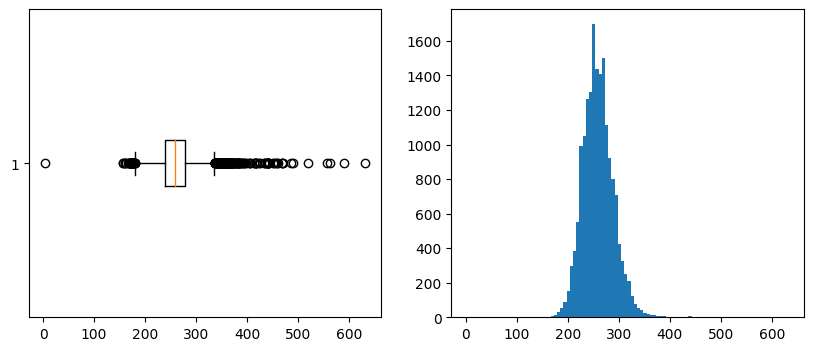

In [115]:
# show the number of times each event occurs
print("Number of events per type over 10 years")
print(df['event_type'].value_counts())

# show the distribution of events per game
events_per_game = df.groupby('game_id').count()['event_type']
print("Events per game")
plt.subplot(1,2,1)
plt.boxplot(events_per_game, vert=False)
plt.subplot(1,2,2)
plt.hist(events_per_game, bins=100)
plt.gcf().set_size_inches(10, 4)
plt.show()

In [104]:
# print a correlation matrix between the columns probability_1, probability_2, probability_3
corr = probabilities_avg[['probability_1', 'probability_2', 'probability_3']].corr()
display(corr)

,probability_1,probability_2,probability_3
probability_1,1.0000000,0.7953449,0.5956938
probability_2,0.7953449,1.0000000,0.5951818
probability_3,0.5956938,0.5951818,1.0000000


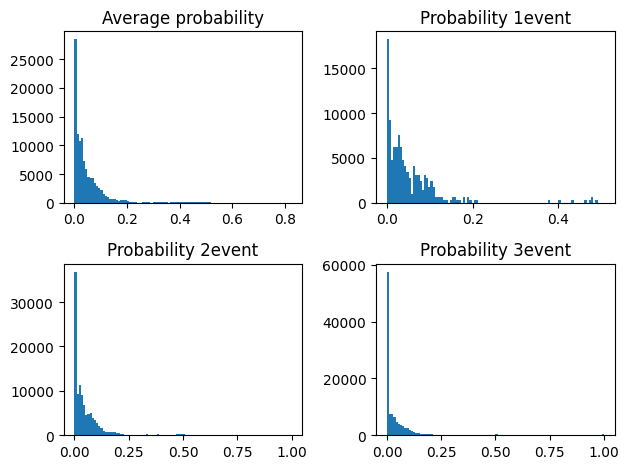

In [120]:

plt.subplot(2, 2, 1)
plt.hist(probabilities_avg['probability_avg'], label="avg", bins=100)
plt.title("Average probability")

plt.subplot(2, 2, 2)
plt.hist(probabilities_avg['probability_1'], label="1event", bins=100)
plt.title("Probability 1event")

plt.subplot(2, 2, 3)
plt.hist(probabilities_avg['probability_2'], label="2event", bins=100)
plt.title("Probability 2event")

plt.subplot(2, 2, 4)
plt.hist(probabilities_avg['probability_3'], label="3event", bins=100)
plt.title("Probability 3event")

plt.tight_layout()
plt.show()


# seconds in game analysis

In [138]:
display(df_orig[df_orig['game_id'] == 2010020048])

,event_type,game_seconds_remaining,event_team_type,home_final,game_id,home_final,away_final,home_name,away_name
28622,GAME_SCHEDULED,3600,NaN,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28623,CHANGE,3600,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28624,CHANGE,3600,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28625,FACEOFF,3600,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
28626,SHOT,3569,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
...,...,...,...,...,...,...,...,...,...
29125,SHOT,3,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29126,CHANGE,0,away,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29127,CHANGE,0,home,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche
29128,PERIOD_END,0,NaN,2.0000000,2010020048,2.0000000,3.0000000,New Jersey Devils,Colorado Avalanche


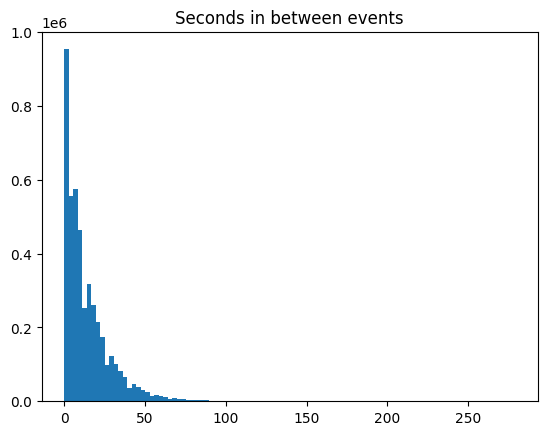

In [12]:
plt.title("Seconds in between events")
df_events['minutes_diff'] = df_events['seconds_diff'] / 60
df_events = df_events[df_events['seconds_diff'] < 400]

plt.hist(df_events['seconds_diff'], bins=100)
plt.show()

# simulate a game

In [21]:
probs = pd.read_csv("data/probabilities_avg.csv")
display(probs)

events = probs['curr_event'].unique()
print(events)

,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921090,0.4921090,0.4921090,0.4921090,17425,17425.0000000,17425.0000000,8575.0000000,8575.0000000,8575.0000000
1,#,#,#,HIT_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,HIT_AWAY,0.0003443,0.0003443,0.0003443,0.0003443,17425,17425.0000000,17425.0000000,6.0000000,6.0000000,6.0000000
3,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111145,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,MISSED_SHOT_HOME,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111146,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,TAKEAWAY_AWAY,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111147,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,GOAL_AWAY,0.0000099,0.0000298,0.0000000,0.0000000,67085,2779.0000000,515.0000000,2.0000000,0.0000000,0.0000000
111148,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,PENALTY_AWAY,0.2654426,0.1176120,0.3544440,0.3242718,67085,2779.0000000,515.0000000,7890.0000000,985.0000000,167.0000000


['FACEOFF_AWAY' 'HIT_HOME' 'HIT_AWAY' 'GIVEAWAY_HOME' 'BLOCKED_SHOT_AWAY'
 'SHOT_AWAY' 'MISSED_SHOT_AWAY' 'GIVEAWAY_AWAY' 'BLOCKED_SHOT_HOME'
 'FACEOFF_HOME' 'SHOT_HOME' 'GOAL_HOME' 'TAKEAWAY_HOME' 'MISSED_SHOT_HOME'
 'TAKEAWAY_AWAY' 'GOAL_AWAY' 'PENALTY_AWAY' 'PENALTY_HOME']


In [58]:
probs_sums = (probs
    .copy()
    .groupby(by=['prev3', 'prev2', 'prev1'])
    [['probability_avg', 'probability_1', 'probability_2', 'probability_3']]
    .sum()
    .reset_index()
    .rename(columns={
        'probability_avg': 'probability_avg_sum',
        'probability_1': 'probability_1_sum',
        'probability_2': 'probability_2_sum',
        'probability_3': 'probability_3_sum'}))

display(probs_sums)

probs2 = pd.merge(probs, probs_sums, on=['prev3', 'prev2', 'prev1'], how='left')
probs2['probability_avg'] /= probs2['probability_avg_sum']
probs2['probability_1'] /= probs2['probability_1_sum']
probs2['probability_2'] /= probs2['probability_2_sum']
probs2['probability_3'] /= probs2['probability_3_sum']
probs2 = probs2.drop(columns=[
    'probability_avg_sum', 'probability_1_sum', 'probability_2_sum', 'probability_3_sum'])

probs2 = probs2.fillna(0)
display(probs2)

,prev3,prev2,prev1,probability_avg_sum,probability_1_sum,probability_2_sum,probability_3_sum
0,#,#,#,1.0000000,1.0000000,1.0000000,1.0000000
1,#,#,BLOCKED_SHOT_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
2,#,#,BLOCKED_SHOT_HOME,1.0000000,1.0000000,1.0000000,1.0000000
3,#,#,FACEOFF_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
4,#,#,FACEOFF_HOME,1.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...
6170,TAKEAWAY_HOME,TAKEAWAY_HOME,PENALTY_HOME,1.0000000,1.0000000,1.0000000,1.0000000
6171,TAKEAWAY_HOME,TAKEAWAY_HOME,SHOT_AWAY,1.0000000,1.0000000,1.0000000,1.0000000
6172,TAKEAWAY_HOME,TAKEAWAY_HOME,SHOT_HOME,1.0000000,1.0000000,1.0000000,1.0000000
6173,TAKEAWAY_HOME,TAKEAWAY_HOME,TAKEAWAY_AWAY,1.0000000,1.0000000,1.0000000,1.0000000


,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
0,#,#,#,FACEOFF_AWAY,0.4921090,0.4921090,0.4921090,0.4921090,17425,17425.0000000,17425.0000000,8575.0000000,8575.0000000,8575.0000000
1,#,#,#,HIT_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
2,#,#,#,HIT_AWAY,0.0003443,0.0003443,0.0003443,0.0003443,17425,17425.0000000,17425.0000000,6.0000000,6.0000000,6.0000000
3,#,#,#,GIVEAWAY_HOME,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
4,#,#,#,BLOCKED_SHOT_AWAY,0.0000574,0.0000574,0.0000574,0.0000574,17425,17425.0000000,17425.0000000,1.0000000,1.0000000,1.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111145,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,MISSED_SHOT_HOME,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111146,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,TAKEAWAY_AWAY,0.0000050,0.0000149,0.0000000,0.0000000,67085,2779.0000000,515.0000000,1.0000000,0.0000000,0.0000000
111147,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,GOAL_AWAY,0.0000099,0.0000298,0.0000000,0.0000000,67085,2779.0000000,515.0000000,2.0000000,0.0000000,0.0000000
111148,PENALTY_HOME,PENALTY_HOME,PENALTY_HOME,PENALTY_AWAY,0.2654426,0.1176120,0.3544440,0.3242718,67085,2779.0000000,515.0000000,7890.0000000,985.0000000,167.0000000


In [33]:
display(probs2.groupby(by=['prev3', 'prev2', 'prev1'])[['probability_avg', 'probability_1', 'probability_2', 'probability_3']].sum().describe())

,probability_avg,probability_1,probability_2,probability_3
count,6175.0000000,6175.0000000,6175.0000000,6175.0000000
mean,1.0000000,1.0000000,0.9714980,0.7392713
std,0.0000000,0.0000000,0.1664156,0.4390677
min,1.0000000,1.0000000,0.0000000,0.0000000
25%,1.0000000,1.0000000,1.0000000,0.0000000
50%,1.0000000,1.0000000,1.0000000,1.0000000
75%,1.0000000,1.0000000,1.0000000,1.0000000
max,1.0000000,1.0000000,1.0000000,1.0000000


In [43]:
seconds_distr = df_events['seconds_diff'].to_numpy()

# fit a gaussian KernelDensity on seconds_distr
# Import the necessary module
# Fit a Gaussian KernelDensity on seconds_distr
kde = KernelDensity(kernel='gaussian').fit(seconds_distr[:, np.newaxis])

# sample 10 times from this kde
samples = kde.sample(100000).astype(int).flatten()


In [63]:
# simulate the frickin game

n_games = 100
i = 0

games = []

game_bar = tqdm(total=n_games)

for game_id in range(n_games):
    
    game_id = str(game_id).zfill(8)
    
    seconds_remaining = 3600
    
    prev3 = "#"
    prev2 = "#"
    prev1 = "#"
    
    home_score = 0
    away_score = 0
    
    curr_dict = {e:0 for e in events}
    curr_dict['time_remaining'] = seconds_remaining
    
    game_dicts = [curr_dict.copy()]
    
    while seconds_remaining > 0:
        
        curr_table = probs2[(probs['prev3'] == prev3) & (probs2['prev2'] == prev2) & (probs2['prev1'] == prev1)]

        curr_event = np.random.choice(curr_table['curr_event'], p=curr_table['probability_avg'])
        prev3, prev2, prev1 = prev2, prev1, curr_event
        
        event_time = samples[i]
        i += 1
        
        seconds_remaining -= event_time
        
        curr_dict['time_remaining'] = seconds_remaining
        curr_dict[curr_event] += 1
        game_dicts.append(curr_dict.copy())
            
    game_bar.update(1)
            
        
    game_df = pd.DataFrame(game_dicts)
    game_df['game_id'] = game_id
    game_df['home_score'] = home_score
    game_df['away_score'] = away_score
    games.append(game_df)

    
    
        
        
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
games_full = pd.concat(games).reset_index(drop=True)
games_full.to_csv("data/simulated_games.csv", index=False)

In [67]:
last_rows = games_full['game_id'] != games_full['game_id'].shift(-1)

last_rows_df = games_full[last_rows].copy()
last_rows_df = movecol(last_rows_df, cols_to_move=['home_score', 'away_score'], ref_col='FACEOFF_AWAY', place='Before')
display(last_rows_df)

,home_score,away_score,FACEOFF_AWAY,HIT_HOME,HIT_AWAY,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY,SHOT_AWAY,MISSED_SHOT_AWAY,GIVEAWAY_AWAY,BLOCKED_SHOT_HOME,FACEOFF_HOME,SHOT_HOME,GOAL_HOME,TAKEAWAY_HOME,MISSED_SHOT_HOME,TAKEAWAY_AWAY,GOAL_AWAY,PENALTY_AWAY,PENALTY_HOME,time_remaining,game_id
271,0,0,29,30,19,7,22,33,13,8,11,31,33,2,9,9,7,0,3,5,-15,00000000
558,0,0,26,25,27,13,18,34,14,7,17,38,26,3,5,10,6,3,6,8,-16,00000001
818,0,0,38,24,27,14,18,20,5,7,8,27,31,3,11,10,9,1,4,2,-7,00000002
1075,0,0,22,19,21,10,12,30,10,9,22,30,32,5,6,13,4,4,3,4,-12,00000003
1368,0,0,31,28,25,6,20,32,14,6,13,31,35,4,12,17,8,3,5,2,-37,00000004
1622,0,0,34,20,29,6,20,29,10,8,8,20,32,1,10,10,6,4,2,4,-2,00000005
1895,0,0,19,32,19,12,13,35,15,7,12,40,15,2,10,18,13,4,1,5,-5,00000006
2138,0,0,30,13,27,10,11,24,9,6,11,24,31,1,4,12,9,2,7,11,-6,00000007
2382,0,0,27,18,21,15,6,33,7,11,18,25,34,5,5,7,3,1,2,5,-24,00000008
2673,0,0,38,31,24,10,9,38,11,9,16,25,38,1,9,12,6,5,5,3,-4,00000009


In [52]:
display(games_full)

,FACEOFF_AWAY,HIT_HOME,HIT_AWAY,GIVEAWAY_HOME,BLOCKED_SHOT_AWAY,SHOT_AWAY,MISSED_SHOT_AWAY,GIVEAWAY_AWAY,BLOCKED_SHOT_HOME,FACEOFF_HOME,SHOT_HOME,GOAL_HOME,TAKEAWAY_HOME,MISSED_SHOT_HOME,TAKEAWAY_AWAY,GOAL_AWAY,PENALTY_AWAY,PENALTY_HOME,time_remaining,game_id,home_score,away_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3600,00000000,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3600,00000000,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3595,00000000,0,0
3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3593,00000000,0,0
4,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3590,00000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,31,30,35,9,11,27,12,12,11,34,36,4,12,9,6,3,3,1,23,00000009,0,0
2670,31,30,35,9,11,27,12,12,11,34,36,4,12,9,6,3,4,1,8,00000009,0,0
2671,31,30,35,9,11,27,12,12,11,35,36,4,12,9,6,3,4,1,6,00000009,0,0
2672,31,30,35,9,11,27,12,13,11,35,36,4,12,9,6,3,4,1,5,00000009,0,0


In [59]:

display(probs2[probs2['curr_event'].isin(['GOAL_HOME', 'GOAL_AWAY'])].sort_values(by='probability_avg', ascending=False).head(100))

,prev3,prev2,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3,given_count_1,given_count_2,given_count_3,join_count_1,join_count_2,join_count_3
231,#,#,GOAL_HOME,GOAL_AWAY,0.6698923,0.0096770,1.0000000,1.0000000,52392,1.0000000,1.0000000,507.0000000,1.0000000,1.0000000
5483,#,GOAL_AWAY,GOAL_AWAY,GOAL_HOME,0.3558784,0.0088118,0.0588235,1.0000000,48004,17.0000000,1.0000000,423.0000000,1.0000000,1.0000000
107007,PENALTY_HOME,SHOT_AWAY,GIVEAWAY_HOME,GOAL_AWAY,0.3536058,0.0290065,0.0318109,1.0000000,176202,17384.0000000,1.0000000,5111.0000000,553.0000000,1.0000000
68339,SHOT_HOME,GOAL_HOME,GOAL_AWAY,GOAL_HOME,0.3528715,0.0088118,0.2998028,0.7500000,48004,507.0000000,8.0000000,423.0000000,152.0000000,6.0000000
9771,FACEOFF_AWAY,GOAL_HOME,HIT_HOME,GOAL_AWAY,0.3515636,0.0092364,0.0454545,1.0000000,418130,22.0000000,1.0000000,3862.0000000,1.0000000,1.0000000
103943,PENALTY_AWAY,MISSED_SHOT_HOME,MISSED_SHOT_HOME,GOAL_HOME,0.3475716,0.0186852,0.0240297,1.0000000,215037,16979.0000000,1.0000000,4018.0000000,408.0000000,1.0000000
106629,PENALTY_HOME,BLOCKED_SHOT_AWAY,FACEOFF_AWAY,GOAL_AWAY,0.3417853,0.0113569,0.0139989,1.0000000,496260,23359.0000000,1.0000000,5636.0000000,327.0000000,1.0000000
46235,MISSED_SHOT_AWAY,GOAL_AWAY,GOAL_HOME,GOAL_HOME,0.3389453,0.0002481,0.0165877,1.0000000,52392,422.0000000,2.0000000,13.0000000,7.0000000,2.0000000
40403,SHOT_AWAY,GOAL_AWAY,GOAL_HOME,GOAL_HOME,0.3389453,0.0002481,0.0165877,1.0000000,52392,422.0000000,5.0000000,13.0000000,7.0000000,5.0000000
303,#,#,GOAL_AWAY,GOAL_AWAY,0.3334514,0.0003541,0.5000000,0.5000000,48004,2.0000000,2.0000000,17.0000000,1.0000000,1.0000000


In [62]:
after_goal_df = (probs2[probs2['prev1']
    .isin(['GOAL_HOME', 'GOAL_AWAY'])]
    [['prev1', 'curr_event'] + ['probability_avg', 'probability_1', 'probability_2', 'probability_3']]
    .sort_values(by='probability_1', ascending=False)
    .drop_duplicates(subset=['prev1', 'curr_event']))

display(after_goal_df)

,prev1,curr_event,probability_avg,probability_1,probability_2,probability_3
59193,GOAL_HOME,FACEOFF_HOME,0.5067421,0.4900366,0.5136150,0.5165746
58617,GOAL_AWAY,FACEOFF_HOME,0.7383031,0.4766061,1.0000000,0.0000000
46944,GOAL_AWAY,FACEOFF_AWAY,0.2381260,0.4762520,0.0000000,0.0000000
55944,GOAL_HOME,FACEOFF_AWAY,0.4848928,0.4633150,0.4729422,0.5184211
82517,GOAL_HOME,SHOT_AWAY,0.0054996,0.0161857,0.0003130,0.0000000
95878,GOAL_AWAY,SHOT_HOME,0.0079617,0.0156237,0.0002997,0.0000000
30040,GOAL_HOME,PENALTY_AWAY,0.0103106,0.0100588,0.0084507,0.0124224
26799,GOAL_HOME,GOAL_AWAY,0.0226534,0.0096770,0.0133394,0.0449438
9701,GOAL_AWAY,PENALTY_HOME,0.0045773,0.0088743,0.0048577,0.0000000
22007,GOAL_AWAY,GOAL_HOME,0.0029373,0.0088118,0.0000000,0.0000000
